In [1]:
def enumerate_smiles(smiles):#列举同一分子smiles的等价表达,得到规范化的smiles
    mol = Chem.MolFromSmiles(smiles)
    smi = Chem.MolToSmiles(mol,doRandom=False,canonical=False)
    return smi
from rdkit import Chem

# 创建分子对象（示例：乙醇）
T = '[H]'
print(enumerate_smiles(T))
mol = Chem.MolFromSmiles(T)

# 显式添加氢（可选，使氢原子可见）
mol = Chem.AddHs(mol)

# 遍历每个原子并打印信息
for atom in mol.GetAtoms():
    atom_idx = atom.GetIdx()          # 原子索引
    element = atom.GetSymbol()        # 元素种类
    bond_count = atom.GetDegree()     # 成键数目（显式连接的原子数）
    total_degree = atom.GetTotalDegree()  # 总连接数（包括隐式氢）
    
    print(f"原子索引 {atom_idx}: "
          f"元素 = {element}, "
          f"成键数目 = {bond_count}, "
          f"总连接数 = {total_degree}")

[H]
原子索引 0: 元素 = H, 成键数目 = 0, 总连接数 = 0


[14:51:19] WARNING: not removing hydrogen atom without neighbors
[14:51:19] WARNING: not removing hydrogen atom without neighbors


In [2]:
from openbabel import openbabel as ob

def print_atom_indices(smiles_or_filename):
    # 创建 Open Babel 对象
    conv = ob.OBConversion()
    mol = ob.OBMol()
    
    # 判断输入是 SMILES 还是文件名
    if "." in smiles_or_filename or "/" in smiles_or_filename or "\\" in smiles_or_filename:
        # 从文件读取分子
        if not conv.ReadFile(mol, smiles_or_filename):
            print(f"无法读取文件: {smiles_or_filename}")
            return
    else:
        # 从 SMILES 字符串读取分子
        conv.SetInFormat("smi")
        if not conv.ReadString(mol, smiles_or_filename):
            print(f"无效的 SMILES 字符串: {smiles_or_filename}")
            return
    
    # 添加氢原子（可选，显示所有氢）
    mol.AddHydrogens()
    
    # 获取原子总数
    num_atoms = mol.NumAtoms()
    print(f"分子包含 {num_atoms} 个原子:")
    
    # 遍历所有原子并打印信息
    for i in range(1, num_atoms + 1):  # Open Babel 原子索引从 1 开始
        atom = mol.GetAtom(i)
        atomic_num = atom.GetAtomicNum()
        element = ob.GetSymbol(atomic_num)
        print(f"原子序号: {i}, 元素: {element}")

# 示例用法：
# 1. 从 SMILES 字符串创建
print("从 SMILES 创建:")
print_atom_indices(T)  # 乙醇

从 SMILES 创建:
分子包含 1 个原子:
原子序号: 1, 元素: H


In [3]:
import importlib

SAFE_MODULES = {'math', 'numpy', 'os.path', 'datetime', 'json'}  # 允许的安全模块白名单

def safe_import_function(func_path):
    """
    安全导入函数（使用模块白名单）
    格式: "包名.模块名.函数名" 或 "模块名.函数名"
    """
    parts = func_path.split('.')
    if len(parts) < 2:
        raise ValueError("无效的函数路径格式")
    
    # 检查模块是否在白名单中
    module_name = '.'.join(parts[:-1])
    if module_name not in SAFE_MODULES:
        raise ImportError(f"模块 {module_name} 不在安全白名单中")
    
    module = importlib.import_module(module_name)
    return getattr(module, parts[-1])

# 使用示例
if __name__ == "__main__":
    func_str = input("请输入函数路径: ")  # 例如 "math.sqrt"
    try:
        func = safe_import_function(func_str)
        print(f"成功导入函数: {func.__name__}")
        # 测试调用（添加基本类型检查）
        if func.__name__ in ['sqrt', 'sin', 'cos']:
            print(f"{func.__name__}(4) = {func(4)}")
    except (ImportError, AttributeError, ValueError) as e:
        print(f"错误: {str(e)}")

错误: 无效的函数路径格式


In [4]:
from ase.io import read
import numpy as np

def get_fmax_from_traj(traj_file):
    """
    从轨迹文件中提取所有步骤的 fmax 值
    
    参数:
        traj_file: 轨迹文件路径
        
    返回:
        steps: 步骤编号列表
        fmax_values: 每个步骤对应的 fmax 值列表
    """
    # 读取轨迹文件中的所有结构
    structures = read(traj_file, index=':')
    
    steps = []
    fmax_values = []
    
    for i, atoms in enumerate(structures):
        # 获取当前结构的力
        forces = atoms.get_forces()
        
        # 计算每个原子的力大小
        force_magnitudes = np.linalg.norm(forces, axis=1)
        
        # 获取最大力 (fmax)
        fmax = np.max(force_magnitudes)
        
        steps.append(i)
        fmax_values.append(fmax)
    
    return steps, fmax_values

# 使用示例
steps, fmax_values = get_fmax_from_traj('struct_1/opt.vasp')
# 打印结果
print("优化步骤 | fmax (eV/Å)")
print("----------------------")
for step, fmax in zip(steps, fmax_values):
    print(f"{step:8d} | {fmax:.6f}")

# 获取最终 fmax 值
final_fmax = fmax_values[-1]
print(f"\n最终 fmax 值: {final_fmax:.6f} eV/Å")

优化步骤 | fmax (eV/Å)
----------------------
       0 | 0.676709
       1 | 0.499783
       2 | 0.430524
       3 | 0.439393
       4 | 0.551579
       5 | 3.621600
       6 | 0.524514
       7 | 0.496266
       8 | 1.123818
       9 | 0.464147
      10 | 0.276181
      11 | 0.338297
      12 | 0.525603
      13 | 0.672043
      14 | 0.903733
      15 | 1.157199
      16 | 1.089045
      17 | 1.243166
      18 | 1.519343
      19 | 1.797064
      20 | 2.028177
      21 | 1.893965
      22 | 1.888929
      23 | 2.615144
      24 | 2.251621
      25 | 2.410138
      26 | 2.109261
      27 | 1.738531
      28 | 1.629297
      29 | 1.691749
      30 | 1.147584
      31 | 0.517817
      32 | 0.525004
      33 | 0.544097
      34 | 0.561357
      35 | 0.518648
      36 | 0.411623
      37 | 0.218022
      38 | 0.258661
      39 | 0.355161
      40 | 0.276821
      41 | 0.163590
      42 | 0.144310
      43 | 0.166185
      44 | 0.364193
      45 | 0.228371
      46 | 0.195736
      47 | 0.26443

In [5]:
from ase.io import read
import numpy as np

def get_fmax_from_traj(traj_file):
    # 读取轨迹文件的最后一个结构（单个Atoms对象）
    atoms = read(traj_file, index=-1)
    
    # 直接从Atoms对象获取力
    forces = atoms.get_forces()
    force_magnitudes = np.linalg.norm(forces, axis=1)
    fmax = np.max(force_magnitudes)
    return fmax

fmax_value = get_fmax_from_traj('struct_1/opt.vasp')
print(fmax_value)  # 输出单个数值

0.04546015908266299


In [6]:
import random

# 生成10个[0.0, 1.0)范围内的均匀分布随机数
random_numbers = [random.random() for _ in range(10)]
print(random_numbers)

'''# 生成10个[5.0, 10.0)范围内的均匀分布随机数
random_numbers_range = [random.uniform(5.0, 10.0) for _ in range(10)]
print(random_numbers_range)

# 使用NumPy生成更高效的均匀分布随机数组（适合大数据量）
import numpy as np

# 生成10个[0.0, 1.0)范围内的均匀分布随机数
np_random = np.random.rand(10)
print(np_random)

# 生成10个[5.0, 10.0)范围内的均匀分布随机数
np_random_range = np.random.uniform(5.0, 10.0, 10)
print(np_random_range)'''

[0.7757697774134971, 0.9874400256865594, 0.5967349296346918, 0.3017732418244563, 0.335299644700065, 0.5889241794615186, 0.9700354109847088, 0.9034056202926003, 0.9121750787443609, 0.5071826845591596]


'# 生成10个[5.0, 10.0)范围内的均匀分布随机数\nrandom_numbers_range = [random.uniform(5.0, 10.0) for _ in range(10)]\nprint(random_numbers_range)\n\n# 使用NumPy生成更高效的均匀分布随机数组（适合大数据量）\nimport numpy as np\n\n# 生成10个[0.0, 1.0)范围内的均匀分布随机数\nnp_random = np.random.rand(10)\nprint(np_random)\n\n# 生成10个[5.0, 10.0)范围内的均匀分布随机数\nnp_random_range = np.random.uniform(5.0, 10.0, 10)\nprint(np_random_range)'

前10个随机数: [3.74540119 9.50714306 7.31993942 5.98658484 1.5601864  1.5599452
 0.58083612 8.66176146 6.01115012 7.08072578]


C:\Users\renyq\AppData\Local\Temp\ipykernel_18804\53947130.py:40: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\renyq\AppData\Local\Temp\ipykernel_18804\53947130.py:40: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\renyq\AppData\Local\Temp\ipykernel_18804\53947130.py:40: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\renyq\AppData\Local\Temp\ipykernel_18804\53947130.py:40: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\renyq\AppData\Local\Temp\ipykernel_18804\53947130.py:40: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\renyq\AppData\Local\Temp\ipykernel_18804\53947130.py:40: UserWarning: Glyph 21248 (\N{CJK UNIFIE

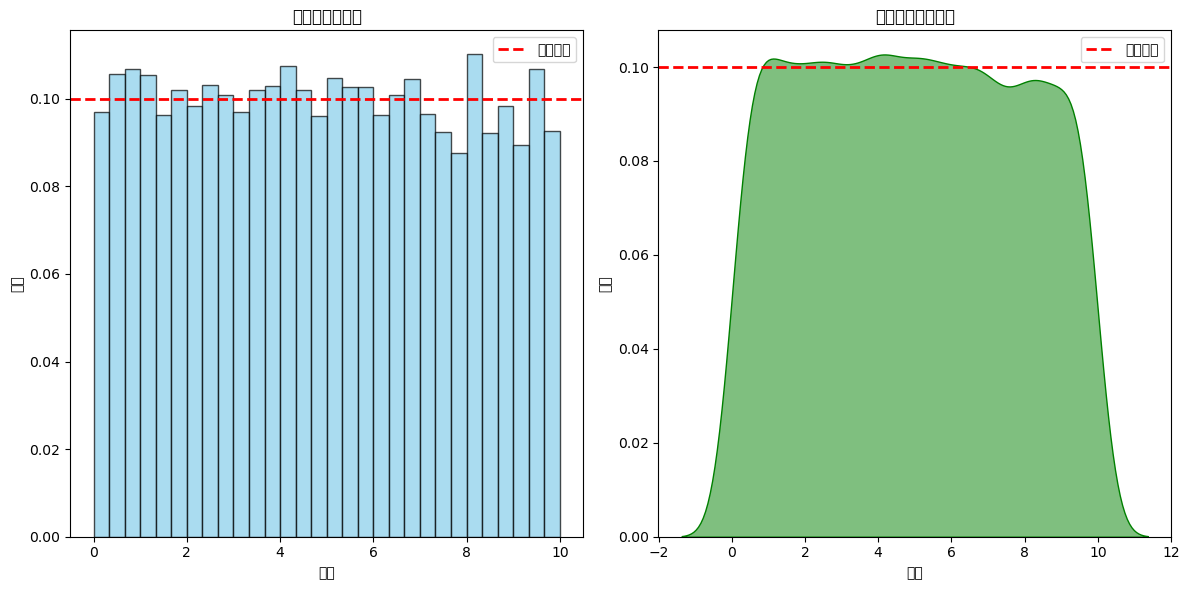

c:\Users\renyq\anaconda3\envs\ASE_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\renyq\anaconda3\envs\ASE_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21248 (\N{CJK UNIFIED IDEOGRAPH-5300}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\renyq\anaconda3\envs\ASE_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\renyq\anaconda3\envs\ASE_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\renyq\anaconda3\envs\ASE_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31665

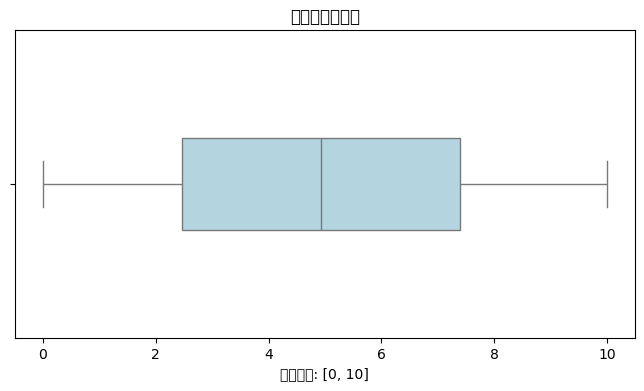


统计信息:
样本数量: 10000
理论范围: [0, 10]
实际最小值: 0.0001
实际最大值: 9.9972
理论均值: 5.0000
实际均值: 4.9416
理论方差: 8.3333
实际方差: 8.2723


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置随机种子保证结果可复现
np.random.seed(42)

# 生成均匀分布随机数
n = 10000  # 样本数量
low = 0    # 最小值
high = 10  # 最大值

# 生成均匀分布的随机数列表
uniform_data = np.random.uniform(low, high, n)

# 打印前10个随机数
print("前10个随机数:", uniform_data[:10])

# 绘制分布图
plt.figure(figsize=(12, 6))

# 直方图
plt.subplot(1, 2, 1)
plt.hist(uniform_data, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.axhline(y=1/(high-low), color='r', linestyle='--', linewidth=2, label='理论密度')
plt.title('均匀分布直方图')
plt.xlabel('数值')
plt.ylabel('密度')
plt.legend()

# 核密度估计图
plt.subplot(1, 2, 2)
sns.kdeplot(uniform_data, color='green', fill=True, alpha=0.5)
plt.axhline(y=1/(high-low), color='r', linestyle='--', linewidth=2, label='理论密度')
plt.title('均匀分布密度估计')
plt.xlabel('数值')
plt.ylabel('密度')
plt.legend()

plt.tight_layout()
plt.show()

# 添加箱线图显示分布范围
plt.figure(figsize=(8, 4))
sns.boxplot(x=uniform_data, color='lightblue', width=0.3)
plt.title('均匀分布箱线图')
plt.xlabel(f'数值范围: [{low}, {high}]')
plt.show()

# 打印统计信息
print(f"\n统计信息:")
print(f"样本数量: {n}")
print(f"理论范围: [{low}, {high}]")
print(f"实际最小值: {np.min(uniform_data):.4f}")
print(f"实际最大值: {np.max(uniform_data):.4f}")
print(f"理论均值: {(low+high)/2:.4f}")
print(f"实际均值: {np.mean(uniform_data):.4f}")
print(f"理论方差: {((high-low)**2)/12:.4f}")
print(f"实际方差: {np.var(uniform_data):.4f}")